In [ ]:
GOOGLE_COLAB = True
path = ""
if GOOGLE_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/image_classification"

/content/drive/MyDrive/Colab Notebooks/image_classification


In [ ]:
#!pip install unrar
!unrar x image_classification.rar

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

tf.test.gpu_device_name()
device_lib.list_local_devices()
!cat /proc/meminfo
!!cat /proc/cpuinfo
!nvidia-smi
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


MemTotal:       13333580 kB
MemFree:         9365004 kB
MemAvailable:   11902348 kB
Buffers:           80292 kB
Cached:          2483916 kB
SwapCached:            0 kB
Active:          1133076 kB
Inactive:        2406528 kB
Active(anon):     815776 kB
Inactive(anon):     8544 kB
Active(file):     317300 kB
Inactive(file):  2397984 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              3604 kB
Writeback:             0 kB
AnonPages:        975288 kB
Mapped:           629236 kB
Shmem:              9156 kB
Slab:             172564 kB
SReclaimable:     125932 kB
SUnreclaim:        46632 kB
KernelStack:        4720 kB
PageTables:         9312 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666788 kB
Committed_AS:    3687704 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              952 kB
AnonHugePages:   

In [ ]:

def creat_model():
  import keras
  from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
  from keras.models import Sequential

  model = Sequential()

  model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(150, 150, 3)))
  model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=2, strides=2))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=2, strides=2))
  model.add(Dropout(0.25))

  model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=2, strides=2))
  model.add(Dropout(0.25))

  model.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=2, strides=2))
  model.add(Dropout(0.25))

  model.add(Conv2D(512, kernel_size=3, activation='relu'))
  model.add(Conv2D(512, kernel_size=3, activation='relu'))
  model.add(Conv2D(512, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D(pool_size=2, strides=2))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(4096, activation='relu'))
  model.add(Dense(4096, activation='relu'))
  model.add(Dense(4096, activation='relu'))

  # the data we are using has 6 classes
  model.add(Dense(6, activation='softmax'))

  return model

In [ ]:
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (150, 150))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

train_dir = "/content/drive/MyDrive/Colab Notebooks/image_classification/seg_train/"
validate_dir = "/content/drive/MyDrive/Colab Notebooks/image_classification/seg_test/"
predict_dir = "/content/drive/MyDrive/Colab Notebooks/image_classification/seg_pred/"


print('loading training images')
X_train, y_train = load_data(train_dir)
print('loading test images')
X_validate, y_validate = load_data(validate_dir)
print('loading prediction images')
X_predict, y_predict = load_data(predict_dir)

In [ ]:
vgg16 = creat_model()
vgg16.summary()

In [ ]:
from keras.optimizers import SGD
sgd = SGD(lr=0.01, decay=1e-7, momentum=.9)
vgg16.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
datagen_validate = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/image_classification/seg_train/"
validate_dir = "/content/drive/MyDrive/Colab Notebooks/image_classification/seg_test/"

train_it = datagen_train.flow_from_directory(train_dir, target_size=(150,150),class_mode="categorical", batch_size=64,shuffle=True,)
validate_it = datagen_validate.flow_from_directory(validate_dir, target_size=(150,150),class_mode="categorical", batch_size=64,shuffle=True,)


H = vgg16.fit(train_it,batch_size=64,epochs=50,validation_data=validate_it)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 128)      

In [ ]:
vgg16.save_weights('vgg16_trained_weights_with_data_augmentation.h5')

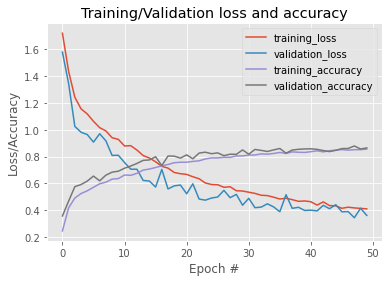

In [ ]:
'''LEARNING CURVE'''

import matplotlib.pyplot as plt
import numpy as np

N = np.arange(0, 50)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='training_loss')
plt.plot(N, H.history['val_loss'], label='validation_loss')
plt.plot(N, H.history['accuracy'], label='training_accuracy')
plt.plot(N, H.history['val_accuracy'], label='validation_accuracy')
plt.title('Training/Validation loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [ ]:
predict_dir = "/content/drive/MyDrive/Colab Notebooks/image_classification/seg_pred/"

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1. / 255)
predict_it = datagen.flow_from_directory(predict_dir, target_size=(150,150),class_mode="categorical", batch_size=1,shuffle=False,)

score = vgg16.evaluate_generator(predict_it)

filenames = predict_it.filenames
nb_samples = len(filenames)
Y_pred = vgg16.predict_generator(predict_it,steps = nb_samples)
y_pred = np.argmax(Y_pred, axis=1)
from sklearn.metrics import classification_report, confusion_matrix
aa=confusion_matrix(predict_it.classes, y_pred)

Found 7301 images belonging to 6 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])
print('Confusion Matrix = \n',aa)

Test Loss =  0.42985329031944275
Test Accuracy =  0.8622106313705444
Confusion Matrix = 
 [[1034   10    4   19    4   73]
 [   8 1141    0    5    2   10]
 [  18    8 1086  170   42    6]
 [   7   10  118 1085   74    3]
 [  37    7   56  109  911    8]
 [ 165   17    5    6    5 1038]]
